In [60]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

In [61]:
speed_of_light = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/speed_of_light) / (1. + v/speed_of_light)
    return np.sqrt(frac)

In [62]:
MODEL_T_COLOR = 'b'
MODEL_STAR_COLOR = 'r'
DATA_COLOR = 'k'

## 51 Peg:

In [63]:
results_51peg = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt0.hdf5')

Results: reading from /Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt0.hdf5


### FIGURE: data and models for random epoch

In [111]:
o = 63 # order
r = np.where(results_51peg.orders == o)[0][0] # index into results to get desired order
e = 7 # epoch
n = np.where(results_51peg.epochs == e)[0][0] # index into results to get desired epoch

In [112]:
data_51peg = wobble.Data(results_51peg.origin_file, filepath='/Users/mbedell/python/wobble/', 
                   orders=[o], epochs=[e])

In [113]:
xs = np.exp(data_51peg.xs[0][0])
ys = np.exp(data_51peg.ys[0][0])
mask = data_51peg.ivars[0][0] <= 1.e-8
resids = ys - np.exp(results_51peg.star_ys_predicted[r][n] 
                            + results_51peg.tellurics_ys_predicted[r][n])

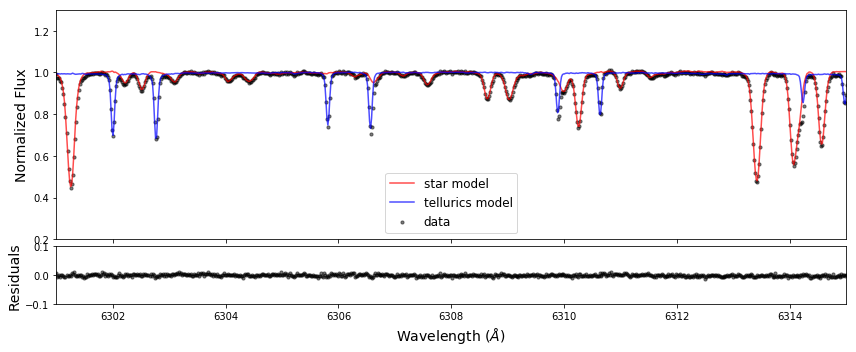

In [115]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(12,5))
ax.scatter(xs, ys, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
ax.scatter(xs[mask], ys[mask], marker=".", alpha=1., c='white', s=20)
ax.plot(xs, np.exp(results_51peg.star_ys_predicted[r][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.7)
ax.plot(xs, np.exp(results_51peg.tellurics_ys_predicted[r][n]), 
                color=MODEL_T_COLOR, label='tellurics model', lw=1.5, alpha=0.7)
ax.set_xticklabels([])
ax.set_ylabel('Normalized Flux', fontsize=14)

ax2.scatter(xs, resids, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
ax2.scatter(xs[mask], resids[mask], marker=".", alpha=1., c='white', s=20)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Residuals', fontsize=14)

ax.set_xlim([6301,6315])
ax2.set_xlim([6301,6315])
ax.set_ylim([0.2,1.3])

ax.legend(fontsize=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig('51peg_telluriczoom.png')

### FIGURE: orbit fit

In [227]:
from numpy import log, exp, pi, sqrt, sin, cos, tan, arctan

def calc_ma(T0, t, period):
    # calculate mean anomaly
    days = t - T0
    phase = days/period % 1.0
    ma = phase * 2.0 * pi
    return ma
    
def calc_ea(ma, ecc):
    # calculate eccentric anomaly from mean anomaly, eccentricity
    tolerance = 1e-3
    ea = np.copy(ma)
    while True:
        diff = ea - ecc * sin(ea) - ma
        ea -= diff / (1. - ecc * cos(ea))
        if abs(diff).all() <= tolerance:
            break
    return ea
 
    
def calc_rvs(t,par):
    '''
    Calculate RV(t) given par
    par: [period, K, ecc, omega, M0, offset]
    where omega is the argument of periastron
    and Tp is time at periastron
    '''
    P,K,ecc,omega,tp,offset = par
    
    # enforce boundaries on parameters:
    #if (P < 0.0 or K < 0.0 or ecc < 0.0 or ecc > 0.999 or omega < 0. or omega > 2.*pi or M0 < 0. or M0 > 2.*pi):
    #    return np.zeros_like(t)
    #P = max([0.0, P])
    #K = max([0.0, K])
    #ecc = min([max([0.0, ecc]), 0.99])
    #omega = min([max([-pi, omega]), pi])
    #M0 = min([max([-pi, M0]), pi])
    
    ma = 2. * pi / P * (t - tp)  # mean anomaly
    ea = calc_ea(ma, ecc)  # eccentric anomaly

    f = 2.0 * np.arctan2(sqrt(1+ecc)*sin(ea/2.0), sqrt(1-ecc)*cos(ea/2.0)) # true anomaly
    rvs = - K * (cos(omega + f) + ecc*cos(omega))
    return rvs + offset

def calc_msini(P, K, ecc, Mstar=1.0):
    '''
    works in the limit that msini << Mstar
    takes:
    K - RV semi-amplitude in m/s
    P - period in days
    ecc - eccentricity (dimensionless)
    Mstar - host star mass in solar masses (default 1)
    returns:
    msini - minimum mass in Jupiters
    '''
    scaled_k = np.abs(K) / 28.4329 * np.sqrt(1. - ecc**2)
    msini = scaled_k * (P / 365.)**(1./3.) * Mstar**(2./3.)
    return msini

    
def keplerian(par,x):
    return calc_rvs(x, par)

def resid(par,fn,x,y,yerr):
    model = fn(par,x)
    return (y - model)/yerr 

In [228]:
rvs = results_51peg.star_time_rvs + results_51peg.bervs
sigs = np.ones_like(rvs) # HACK!!!!
dates = results_51peg.dates - 2450000

In [229]:
from scipy.optimize import leastsq
par0 = np.asarray([4.2308, 55.65, 0.001, 90 * np.pi/180., 0., 0.])  # [period, K, ecc, omega, tp, offset]
soln = leastsq(resid, par0, args=(keplerian, dates, rvs, sigs))

chisq = 71.98
resids RMS = 0.89 m/s
planet period = 4.2306 days
planet msini = 0.45 MJup


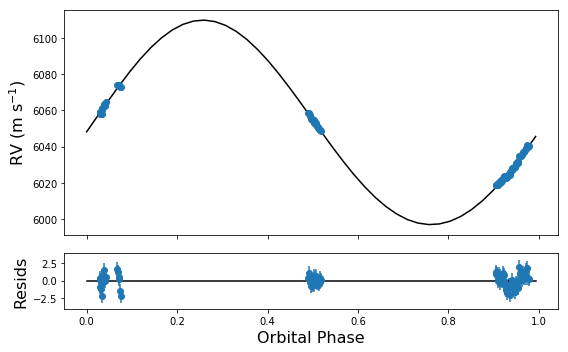

In [230]:
par = soln[0]
period = par[0]
date_fold = dates % period
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(8,5))

ax1.errorbar(date_fold/period, rvs, sigs, fmt='o')
xs = np.arange(0.,period,0.1)
ax1.plot(xs/period, calc_rvs(xs, par), color='k')
#ax1.set_ylim([-80, 80])
ax1.set_xticklabels('',visible=False)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=16)

ax2.set_ylim([-4, 4])


resids = resid(par,keplerian,dates,rvs,sigs)
ax2.errorbar(date_fold/period, resids, sigs, fmt='o')
ax2.plot(xs/period, np.zeros_like(xs), color='k')
print('chisq = {0:.2f}'.format(np.sum(resids**2/sigs**2)))
print('resids RMS = {0:.2f} m/s'.format(np.std(resids)))
print('planet period = {0:.4f} days'.format(period))
print('planet msini = {0:.2f} MJup'.format(calc_msini(*par[:3])))
fig.subplots_adjust(hspace=.05)
ax2.set_ylabel('Resids', fontsize=16)
ax2.set_xlabel('Orbital Phase', fontsize=16)
fig.tight_layout()
plt.savefig('51peg_planet.png')

## tellurics model 
#### (still using 51 Peg data)

### FIGURE: tellurics compared to standard star

In [48]:
from harps_hacks import read_harps
from wobble.utils import fit_continuum
f = '/Users/mbedell/python/wobble/data/telluric/HARPS.2009-05-09T23:40:43.280_e2ds_A.fits'
wave,flux = read_harps.read_spec_2d(f)
snrs = read_harps.read_snr(f)
print(snrs[57])

ModuleNotFoundError: No module named 'harps_hacks'

In [49]:
o = 57
wave2,flux2 = np.exp(data.wobble_obj.model_xs_t[o]), np.exp(data.wobble_obj.model_ys_t[o])
wave1,flux1 = wave[o], flux[o]
ivars1 = np.zeros_like(flux1) + snrs[o]**2 # HACK
flux1 = np.exp(np.log(flux1) - fit_continuum(np.log(wave1), np.log(flux1), ivars1))

AttributeError: 'Data' object has no attribute 'wobble_obj'

NameError: name 'wave2' is not defined

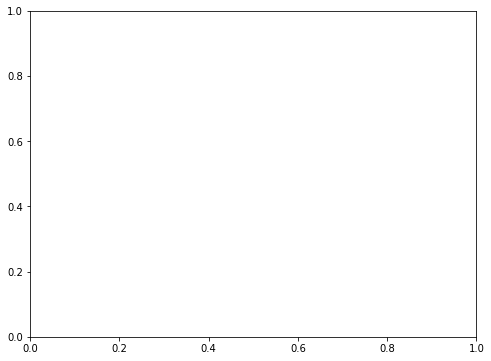

In [50]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(wave2,flux2,color=MODEL_T_COLOR,alpha=0.7,label='model')
ax.plot(wave1,flux1,color=DATA_COLOR,alpha=0.8,label='standard star')
ax.set_xlim([min(wave2),max(wave2)])
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=18)
ax.set_ylabel('Normalized Flux', fontsize=18)
ax.legend(loc='upper right', fontsize=16)
fig.tight_layout()
fig.savefig('telluric_standard.pdf')

### FIGURE: telluric components and variability

## quiet M star:

In [73]:
results_barnards = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_barnards_Kstar0_Kt0.hdf5')

Results: reading from /Users/mbedell/python/wobble/results/results_barnards_Kstar0_Kt0.hdf5


### FIGURE: data and models for random epoch

In [202]:
o = 63 # order
r = np.where(results_barnards.orders == o)[0][0] # index into results to get desired order
e = 155 # epoch
n = np.where(results_barnards.epochs == e)[0][0] # index into results to get desired epoch

In [203]:
data_barnards = wobble.Data(results_barnards.origin_file, filepath='/Users/mbedell/python/wobble/', 
                   orders=[o], epochs=[e])

In [204]:
xs = np.exp(data_barnards.xs[0][0])
ys = np.exp(data_barnards.ys[0][0])
mask = data_barnards.ivars[0][0] <= 1.e-8
resids = ys - np.exp(results_barnards.star_ys_predicted[r][n] 
                            + results_barnards.tellurics_ys_predicted[r][n])

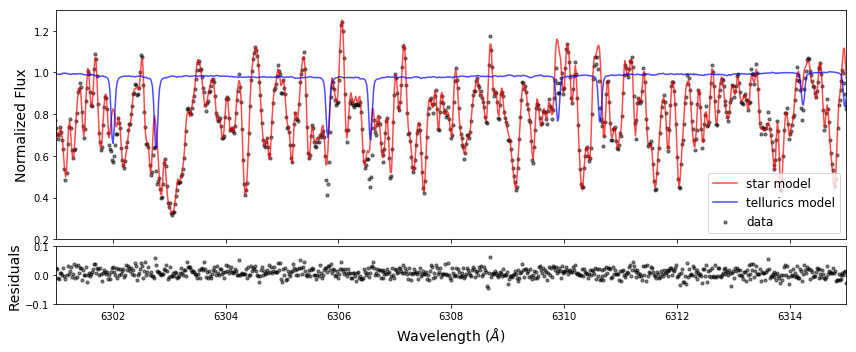

In [226]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(12,5))
ax.scatter(xs, ys, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
ax.scatter(xs[mask], ys[mask], marker=".", alpha=1., c='white', s=20)
ax.plot(xs, np.exp(results_barnards.star_ys_predicted[r][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.7)
ax.plot(xs, np.exp(results_barnards.tellurics_ys_predicted[r][n]), 
                color=MODEL_T_COLOR, label='tellurics model', lw=1.5, alpha=0.7)
ax.set_xticklabels([])
ax.set_ylabel('Normalized Flux', fontsize=14)

ax2.scatter(xs, resids, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
ax2.scatter(xs[mask], resids[mask], marker=".", alpha=1., c='white', s=20)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Residuals', fontsize=14)

ax.set_xlim([6301,6315])
ax2.set_xlim([6301,6315])
ax.set_ylim([0.2,1.3])

ax.legend(fontsize=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig('barnards_telluriczoom.png')

### FIGURE: comparison to PHOENIX model

In [206]:
from astropy.io import fits
hdul = fits.open('/Users/mbedell/python/wobble/data/lte03300-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
model_ys = np.copy(hdul[0].data)
hdul = fits.open('/Users/mbedell/python/wobble/data/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
model_xs = np.copy(hdul[0].data)

In [207]:
v_sys = 206.e3 # from eyeballing the Balmer region (4020-4050A)

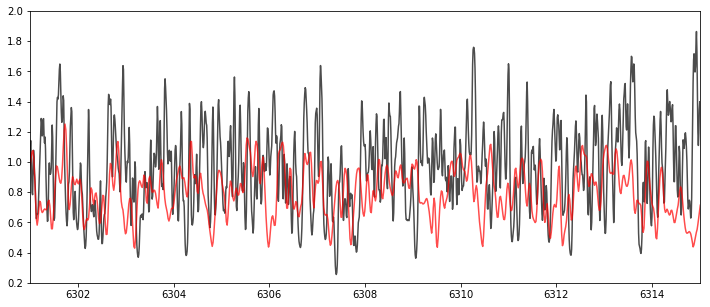

In [216]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(model_xs, model_ys/2.e13, c='k', alpha=0.7)
ax.plot(xs * doppler(v_sys), np.exp(results_barnards.star_ys_predicted[r][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.7)
ax.set_xlim([6301,6315])
ax.set_ylim([0.2,2.]);

### FIGURE: time series

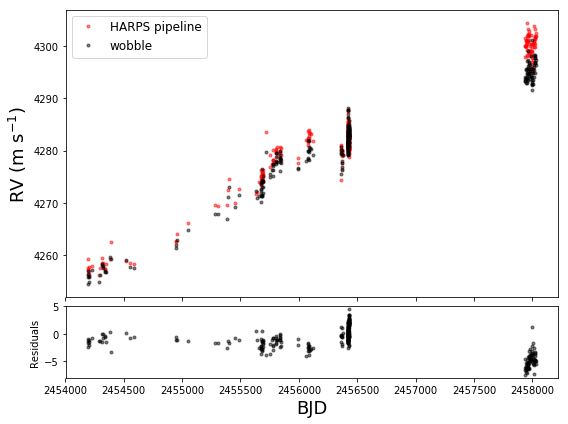

In [225]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(8,6))
rvs = results_barnards.star_time_rvs + results_barnards.bervs
pipeline_rvs = results_barnards.pipeline_rvs + results_barnards.bervs
ax.plot(results_barnards.dates, pipeline_rvs, 'r.', alpha=0.5, label='HARPS pipeline')
ax.plot(results_barnards.dates, rvs, 'k.', alpha=0.5, label='wobble')
ax.set_ylabel(r'RV (m s$^{-1}$)', fontsize=18)
ax.set_xticklabels([])

ax2.plot(results_barnards.dates, rvs - pipeline_rvs, 'k.', alpha=0.5)
ax2.set_xlabel('BJD', fontsize=18)
ax2.set_ylabel('Residuals')

ax.legend(fontsize=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig('barnards_rvs.png')

### FIGURE: tellurics comparison

In [ ]:
o = 63
r = np.where(results_barnards.orders == o)[0][0] # index into results to get desired order
xs1 = np.exp(results_barnards.tellurics_template_xs[r])
ys1 = np.exp(results_barnards.tellurics_template_ys[r])
r = np.where(results_51peg.orders == o)[0][0] # index into results to get desired order
xs2 = np.exp(results_51peg.tellurics_template_xs[r])
ys2 = np.exp(results_51peg.tellurics_template_ys[r])

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(12,5))
ax.scatter(xs1, ys1, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
ax.scatter(xs[mask], ys[mask], marker=".", alpha=1., c='white', s=20)
ax.plot(xs, np.exp(results_51peg.star_ys_predicted[r][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.7)
ax.plot(xs, np.exp(results_51peg.tellurics_ys_predicted[r][n]), 
                color=MODEL_T_COLOR, label='tellurics model', lw=1.5, alpha=0.7)
ax.set_xticklabels([])
ax.set_ylabel('Normalized Flux', fontsize=14)

ax2.scatter(xs, resids, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
ax2.scatter(xs[mask], resids[mask], marker=".", alpha=1., c='white', s=20)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Residuals', fontsize=14)

ax.legend(fontsize=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig('51peg_spectrum.png')